In [23]:
%matplotlib inline

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Params

In [43]:
def visualise(vars, labels=None):
    height, width = vars[0].shape[1:]
    fig, axes = plt.subplots(height, width, sharex=True, sharey=True, figsize=(15,10))
    for i in range(height):
        for j in range(width):
            actors = [axes[i,j].plot(v[:,i,j])[0] for v in vars]
            
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
    
    if labels is not None:
        fig.legend(actors, labels, loc="lower center", ncol=len(labels))

def hide_axes(axis):
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

In [59]:
WIDTH = 16
HEIGHT = 16
TIMESTEPS = 16

# Stimuli generation

In [69]:
STIM_WIDTH = 2
STIM_HEIGHT = 2
STIM_Y = 8

images = np.ones((TIMESTEPS, HEIGHT, WIDTH))
for i in range(TIMESTEPS):
    images[i,STIM_Y:STIM_Y+STIM_HEIGHT,i:i+STIM_WIDTH] = 0.0

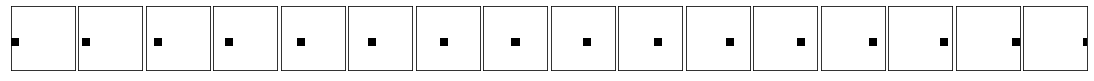

In [70]:
fig, axes = plt.subplots(1,TIMESTEPS, sharey=True, figsize=(15,5))
for t, a in enumerate(axes):
    a.imshow(images[t,:,:], cmap="gray")
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
fig.tight_layout(pad=0)


# High-pass filters

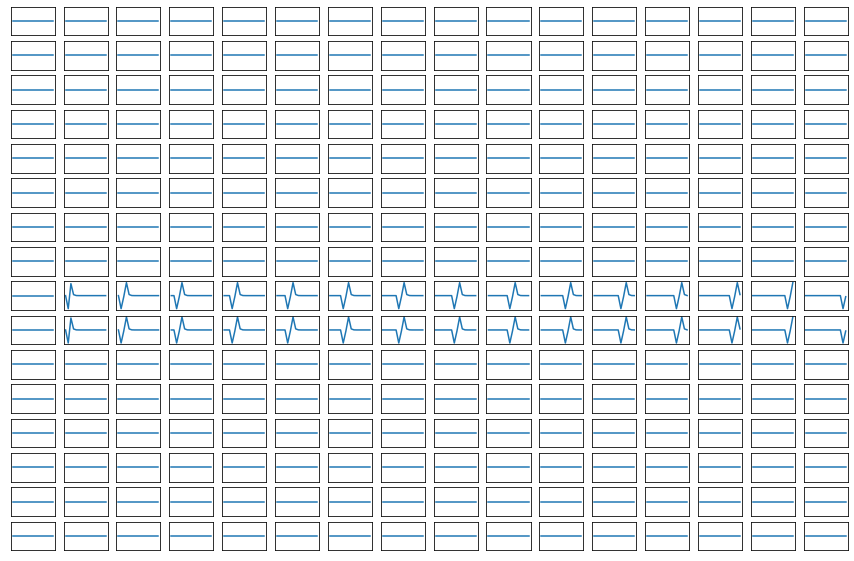

In [71]:
LPF_TAU = 0.4

# EMA time constant
LPF_K = np.exp(-1 / LPF_TAU)

lpf = np.ones((TIMESTEPS, HEIGHT, WIDTH))
f = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
for t in range(1, TIMESTEPS):
    lpf[t] = (LPF_K * lpf[t - 1]) + ((1.0 - LPF_K) * images[t])
    f[t] = (images[t] - lpf[t])

visualise([f])

# Half-wave rectification

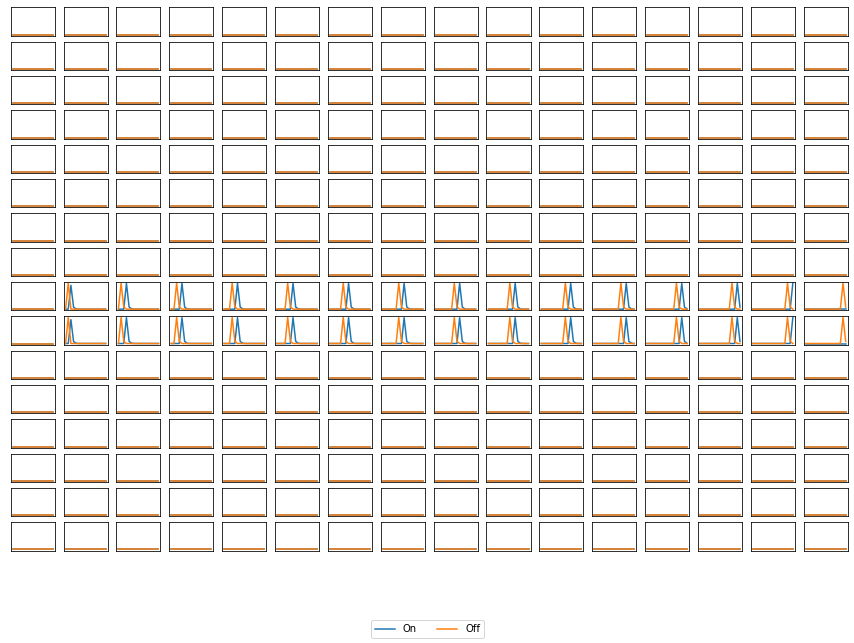

In [72]:
on_f = np.maximum(f, 0.0)
off_f = -np.minimum(f, 0.0)

visualise([on_f, off_f], ["On", "Off"])

# Calculate inhibition

In [ ]:
INHIB_KERNEL = 0.2 * np.asarray([2.0, 1.0, 0.0, 1.0, 2.0])

INHIB_LPF_TAU = 2.0

# EMA time constant
INHIB_LPF_K = np.exp(-1 / INHIB_LPF_TAU)

on_inhib_lpf = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
off_inhib_lpf = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
for t in range(1, TIMESTEPS):
    on_inhib_lpf[t] = (INHIB_LPF_K * on_inhib_lpf[t - 1]) + ((1.0 - INHIB_LPF_K) * on_f[t])
    off_inhib_lpf[t] = (INHIB_LPF_K * off_inhib_lpf[t - 1]) + ((1.0 - INHIB_LPF_K) * off_f[t])


on_conv_inhib = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
off_conv_inhib = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
for t in range(TIMESTEPS):
    on_conv_inhib[t] = cv2.filter2D(on_inhib_lpf[t], -1, INHIB_KERNEL)
    off_conv_inhib[t] = cv2.filter2D(off_inhib_lpf[t], -1, INHIB_KERNEL)


fig, axes = plt.subplots(2,TIMESTEPS, sharey=True, figsize=(15, 5))
for t in range(TIMESTEPS):
    axes[0,t].imshow(on_conv_inhib[t,:,:], cmap="gray")
    axes[1,t].imshow(off_conv_inhib[t,:,:], cmap="gray")
    
    hide_axes(axes[0,t])
    hide_axes(axes[1,t])
fig.tight_layout(pad=0)

# FDSR

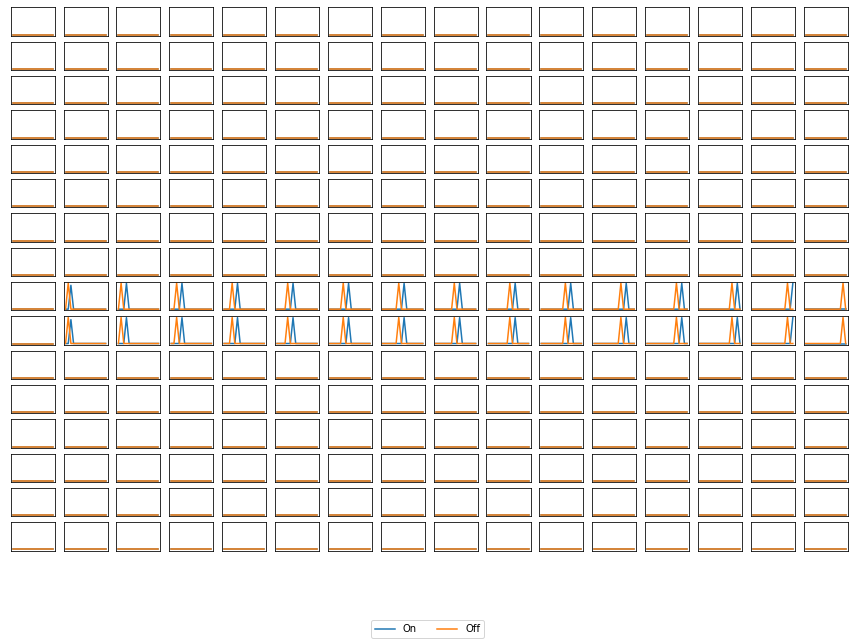

In [74]:
FDSR_TAU_FAST = 1
FDSR_TAU_SLOW = 100

FSR_K_FAST = np.exp(-1 / FDSR_TAU_FAST)
FSR_K_SLOW = np.exp(-1 / FDSR_TAU_SLOW)

a_on = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
a_off = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
for t in range(1, TIMESTEPS):
    # **TODO** independent of time, could be matrix
    k_on = np.where((on_f[t] - on_f[t - 1]) > 0.0, FSR_K_FAST, FSR_K_SLOW)
    k_off = np.where((off_f[t] - off_f[t - 1]) > 0.0, FSR_K_FAST, FSR_K_SLOW)
    
    a_on[t] = ((1.0 - k_on) * on_f[t]) + (k_on * a_on[t - 1]) 
    a_off[t] = ((1.0 - k_off) * off_f[t]) + (k_off * a_off[t - 1]) 

# Rectify
a_on = np.maximum(0.0, on_f - a_on - on_conv_inhib)
a_off = np.maximum(0.0, off_f - a_off - off_conv_inhib)

visualise([a_on, a_off], ["On", "Off"])

# Recombine

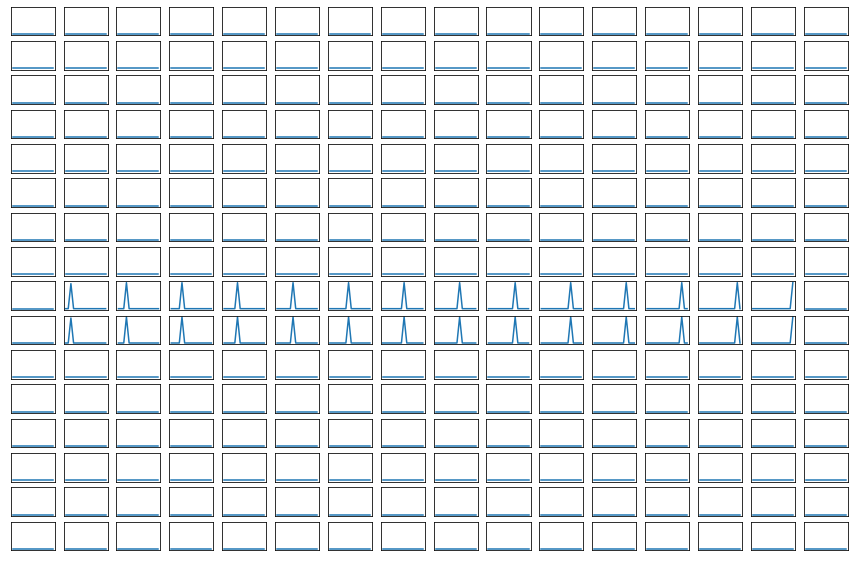

In [75]:
OFF_TAU = 25
OFF_K = np.exp(-1 / OFF_TAU)

off_filter = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
output = np.zeros((TIMESTEPS, HEIGHT, WIDTH))

for t in range(1, TIMESTEPS):
    off_filter[t] = ((1.0 - OFF_K) * a_off[t]) + (OFF_K * off_filter[t - 1]) 
    output[t] = off_filter[t] * a_on[t]

visualise([output])

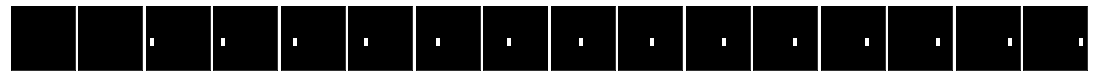

In [76]:
fig, axes = plt.subplots(1,TIMESTEPS, sharey=True, figsize=(15, 5))
for t, a in enumerate(axes):
    a.imshow(output[t,:,:], cmap="gray")
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
fig.tight_layout(pad=0)
